# **Step 1:** Import libraries

In [1]:
# Import libraries

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import time

import warnings
warnings.filterwarnings('ignore')

In [99]:
pip install -U kaleido

In [2]:
pip install git+https://github.com/hyperopt/hyperopt-sklearn

  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-krsr4ww4
  Running command git clone --filter=blob:none --quiet https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-krsr4ww4
  Resolved https://github.com/hyperopt/hyperopt-sklearn to commit 4bc286479677a0bfd2178dac4546ea268b3f3b77
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from hyperopt import tpe
from hpsklearn import HyperoptEstimator, svc

# **Step 2:** Load the dataset. Split the data with test size 0.2.

In [4]:
os.getcwd()

'/content'

In [5]:
os.listdir()

['.config',
 '__MACOSX',
 'IndianCurrencyNotesDataset.zip',
 'IndianCurrencyNotesDataset',
 'sample_data']

In [6]:
f_name = 'IndianCurrencyNotesDataset.zip'
print('Size of ZIP file', os.path.getsize(f_name) / 1024 / 1024, 'MB')

Size of ZIP file 17.619593620300293 MB


In [7]:
# To unzip the archive 'IndianCurrencyNotesDataset.zip' in the current directory

start = time.perf_counter()   # Get current (relative) time in program

with zipfile.ZipFile(f_name, 'r') as fd:
    fd.extractall('.')

end = time.perf_counter()  # Get current (relative) time in program
print('Time to unzip', f_name, ':', end - start, 'seconds')

Time to unzip IndianCurrencyNotesDataset.zip : 0.32238248599969666 seconds


In [8]:
os.listdir()

['.config',
 '__MACOSX',
 'IndianCurrencyNotesDataset.zip',
 'IndianCurrencyNotesDataset',
 'sample_data']

In [9]:
os.listdir('./IndianCurrencyNotesDataset/')

['.DS_Store', 'AllImages']

In [10]:
def count_folders(directory_path):
  '''
    Function to count the number of non-files in a directory.
  '''
  count = 0
  non_folders = []

  for idx, path in enumerate(os.listdir(directory_path)):
      # Check if current path is not a file
      if not os.path.isfile(os.path.join(directory_path, path)):
        count += 1
      else:
        non_folders.append(idx)

  return count, non_folders

In [11]:
def count_images(directory_path):
  '''
    Function to count the number of non-files in a directory.
  '''

  if os.path.isfile(directory_path):
    return None

  count = 0
  for path in os.listdir(directory_path):
    # Check if current path is a file
    if os.path.isfile(os.path.join(directory_path, path)) and path.endswith('.jpg'):
      count += 1

  return count

In [12]:
dir_path = './IndianCurrencyNotesDataset/AllImages'

note_directories = os.listdir(dir_path)
n_folders, non_folders = count_folders(dir_path)
print(f'Number of sub-directories in /AllImages = {n_folders}    No of non-files = {non_folders}\n')
note_directories

Number of sub-directories in /AllImages = 7    No of non-files = [2]



['2000 Note',
 '200 Note',
 '.DS_Store',
 '20 Note',
 '500 Note',
 '100 Note',
 '50 Note',
 '10 Note']

In [13]:
for idx in range(1, len(note_directories)):
  note_dir = note_directories[idx]
  new_path = os.path.join(dir_path, note_dir)

  n_images = count_images(new_path)
  if n_images != None:
    n_non_images = len(os.listdir(new_path)) - n_images
    print(f'Number of images in /{note_dir} = {n_images}; No of non-images = {n_non_images}')

Number of images in /200 Note = 26; No of non-images = 0
Number of images in /20 Note = 25; No of non-images = 0
Number of images in /500 Note = 26; No of non-images = 0
Number of images in /100 Note = 25; No of non-images = 0
Number of images in /50 Note = 25; No of non-images = 0
Number of images in /10 Note = 26; No of non-images = 0


In [14]:
import cv2

img = cv2.imread('./IndianCurrencyNotesDataset/AllImages/10 Note/1.jpg')
img.shape

(168, 300, 3)

In [15]:
img2 = cv2.imread('./IndianCurrencyNotesDataset/AllImages/10 Note/10.jpg')
img2.shape

(239, 404, 3)

In [16]:
batch_size = 32
image_size = (224, 224)

In [17]:
# Generate Training and Testing dataset

train_dataset, test_dataset = image_dataset_from_directory(
    dir_path,
    validation_split = 0.2,
    subset = 'both',
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)

Found 178 files belonging to 7 classes.
Using 143 files for training.
Using 35 files for validation.


In [18]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
for images, labels in train_dataset.take(1):
  print(labels, '\n')
  print(images.shape, type(images), images.dtype)
  break

tf.Tensor([4 0 3 5 5 2 5 1 0 4 3 5 5 3 4 2 0 5 2 0 1 4 5 5 3 1 0 2 2 4 1 3], shape=(32,), dtype=int32) 

(32, 224, 224, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> <dtype: 'float32'>


In [21]:
class_labels = train_dataset.class_names
class_labels

['10 Note',
 '100 Note',
 '20 Note',
 '200 Note',
 '2000 Note',
 '50 Note',
 '500 Note']

# **Step 3:** Do some data augmentation like resizing and rotation (this is only done on the training set). Data augmentation is never done on the test set. Keep batch size 32 and rescale all the images to 224*224. Display few samples from training dataset.

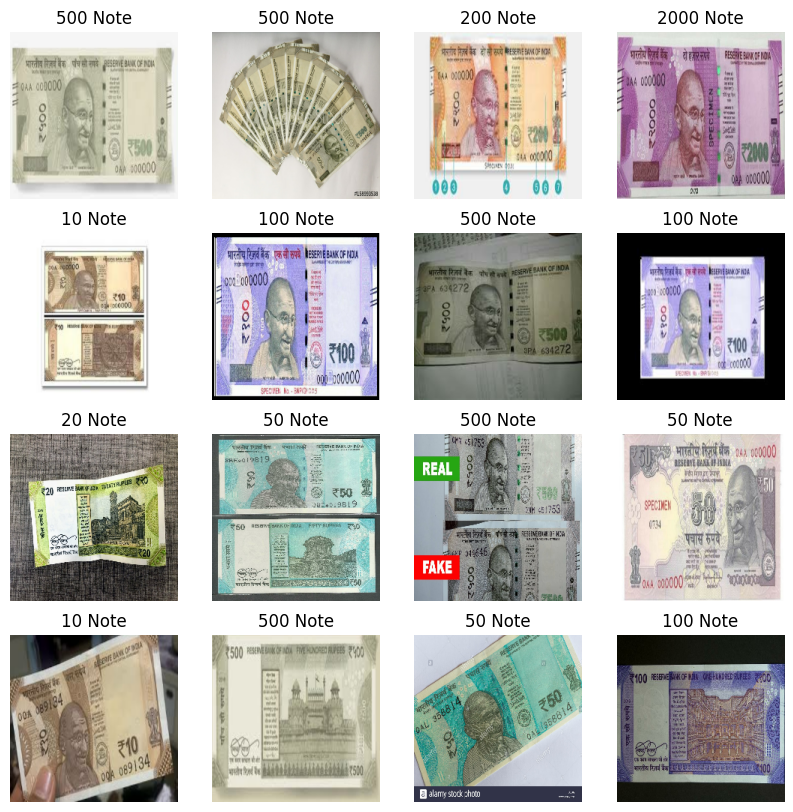

In [22]:
# Display few samples from training dataset

plt.figure(figsize = (10, 10))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_labels[labels[i]])
        plt.axis('off')

plt.show()

In [23]:
# Data Augmentation

data_augmentation = models.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.2),  # Rotation
    layers.experimental.preprocessing.Resizing(224, 224),   # Resizing
])

In [24]:
# Applying Data Augmentation on training set

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

## **Step 4:** Load pretrained ResNet50 model and extract features using this pretrained network. Store the extracted features and its labels in two separate list.

In [25]:
pretrained_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))

In [26]:
pretrained_model

In [27]:
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [28]:
pretrained_model_shape = pretrained_model.layers[-1].output_shape
pretrained_model_shape

(None, 7, 7, 2048)

In [29]:
pretrained_model_shape[1] * pretrained_model_shape[2] * pretrained_model_shape[3]

100352

In [30]:
extracted_features_list = []
extracted_labels_list = []

In [31]:
for images, labels in train_dataset:
    features = pretrained_model.predict(images)
    features_flatten = np.reshape(features, (features.shape[0], -1))
    extracted_features_list.append(features_flatten)
    extracted_labels_list.append(labels.numpy())

1/1 [==============================] - 4s 4s/step


In [32]:
X_train = np.concatenate(extracted_features_list)
y_train = np.concatenate(extracted_labels_list)

In [33]:
print('Shape of X_train = ', X_train.shape)
pd.DataFrame(X_train).head()

Shape of X_train =  (143, 100352)


,0,1,2,3,4,5,6,7,8,9,...,100342,100343,100344,100345,100346,100347,100348,100349,100350,100351
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.740330,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,1.916649,0.0,0.0,0.0,0.0,0.0,0.136651,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,2.269615,0.0,0.295985,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.200996,0.0,0.000000,0.0,2.613216,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,2.590605,0.0,0.000000,0.0


In [34]:
print('Shape of y_train = ', y_train.shape)
pd.DataFrame(y_train).head()

Shape of y_train =  (143,)


,0
0,6
1,6
2,4
3,1
4,1


# **Step 5:** Now train a SVM classifier over extracted features and labels.

In [35]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [36]:
extracted_features_list_test = []
extracted_labels_list_test = []

In [37]:
for images, labels in test_dataset:
    features = pretrained_model.predict(images)
    features_flatten = np.reshape(features, (features.shape[0], -1))
    extracted_features_list_test.append(features_flatten)
    extracted_labels_list_test.append(labels.numpy())

1/1 [==============================] - 1s 833ms/step


In [40]:
X_test = np.concatenate(extracted_features_list_test)
y_test = np.concatenate(extracted_labels_list_test)

In [41]:
print('Shape of X_test = ', X_test.shape)
pd.DataFrame(X_test).head()

Shape of X_test =  (35, 100352)


,0,1,2,3,4,5,6,7,8,9,...,100342,100343,100344,100345,100346,100347,100348,100349,100350,100351
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091602,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.333771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.069700,0.0,0.0


In [42]:
print('Shape of y_test = ', y_test.shape)
pd.DataFrame(y_test).head()

Shape of y_test =  (35,)


,0
0,5
1,6
2,2
3,2
4,4


# **Step 6:** Make predictions after you fit the SVM classifier.

In [43]:
y_pred = svm_clf.predict(X_test)

In [44]:
print('Shape of y_pred = ', y_pred.shape)
pd.DataFrame(y_pred).head()

Shape of y_pred =  (35,)


,0
0,1
1,6
2,1
3,0
4,4


# **Step 7:** Calculate accuracy and print confusion matrix

In [45]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.3142857142857143

In [46]:
cf_matrix = confusion_matrix(y_test, y_pred)      # Index = Actual;  Column = Predicted

In [47]:
cf_matrix

array([[2, 1, 0, 0, 0, 0, 1],
       [0, 2, 0, 0, 1, 0, 0],
       [4, 2, 0, 0, 0, 0, 1],
       [0, 2, 0, 1, 0, 0, 1],
       [1, 3, 0, 0, 1, 0, 1],
       [1, 3, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 5]])

In [48]:
import plotly.express as px

In [49]:
fig = px.imshow(cf_matrix, text_auto = True, aspect = 'auto', color_continuous_scale = 'blues', width=500, height=500,
                title = 'Confusion Matrix',
                labels = dict(x = 'Predicted', y = 'Actual'),
                x = test_dataset.class_names,
                y = test_dataset.class_names)

fig.show()
fig.write_image('Confusion Matrix.png')

# Improving Accuracy by using Hyperparameter tuning

In [70]:
optimal_svm_model = HyperoptEstimator(classifier = svc('mySVC'),
                                  preprocessing = [] ,
                                  algo = tpe.suggest,
                                  max_evals = 200,
                                  trial_timeout = 60)

In [71]:
optimal_svm_model.fit(X_train, y_train)

100%|██████████| 200/200 [00:02<00:00,  2.77s/trial, best loss: 0.3793103448275862]


In [95]:
optimal_svm_model._best_iters

In [72]:
best_svm_model = optimal_svm_model.best_model()
best_svm_model

{'learner': SVC(C=4.292085277542328, coef0=0.18803681576159076, degree=4, gamma='auto',
     kernel='sigmoid', random_state=1, shrinking=False,
     tol=0.0013134222530283514),
 'preprocs': (),
 'ex_preprocs': ()}

In [73]:
svm_clf = best_svm_model['learner']

In [74]:
svm_clf.fit(X_train, y_train)

SVC(C=4.292085277542328, coef0=0.18803681576159076, degree=4, gamma='auto',
    kernel='sigmoid', random_state=1, shrinking=False,
    tol=0.0013134222530283514)

In [75]:
y_pred_svm = svm_clf.predict(X_test)

In [76]:
print('Shape of y_pred = ', y_pred_svm.shape)
pd.DataFrame(y_pred_svm).head()

Shape of y_pred =  (35,)


,0
0,1
1,6
2,2
3,5
4,4


### **Step 7:** Calculate accuracy and print confusion matrix

In [77]:
accuracy = accuracy_score(y_test, y_pred_svm)
accuracy

0.4857142857142857

In [82]:
1 - 0.3793103448275862

0.6206896551724138

In [78]:
cf_matrix = confusion_matrix(y_test, y_pred_svm)      # Index = Actual;  Column = Predicted

In [79]:
cf_matrix

array([[2, 0, 1, 0, 0, 0, 1],
       [0, 3, 0, 0, 0, 0, 0],
       [1, 1, 3, 0, 0, 2, 0],
       [0, 1, 1, 2, 0, 0, 0],
       [0, 3, 0, 0, 3, 0, 0],
       [0, 2, 0, 0, 0, 1, 2],
       [0, 3, 0, 0, 0, 0, 3]])

In [80]:
import plotly.express as px

In [81]:
fig = px.imshow(cf_matrix, text_auto = True, aspect = 'auto', color_continuous_scale = 'blues', width=500, height=500,
                title = 'Confusion Matrix with Hyperparameter tuning for SVM',
                labels = dict(x = 'Predicted', y = 'Actual'),
                x = test_dataset.class_names,
                y = test_dataset.class_names)

fig.show()
fig.write_image('Confusion Matrix with Hyperparameter tuning for SVM.png')